In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import randint, uniform

# Análise de Dados

In [12]:
df = pd.read_csv('asthma_disease_data.csv')
df = df.drop(columns=['DoctorInCharge', 'PatientID', 'EducationLevel', 'Ethnicity', 'Gender'])

In [13]:
df.columns

Index(['Age', 'BMI', 'Smoking', 'PhysicalActivity', 'DietQuality',
       'SleepQuality', 'PollutionExposure', 'PollenExposure', 'DustExposure',
       'PetAllergy', 'FamilyHistoryAsthma', 'HistoryOfAllergies', 'Eczema',
       'HayFever', 'GastroesophagealReflux', 'LungFunctionFEV1',
       'LungFunctionFVC', 'Wheezing', 'ShortnessOfBreath', 'ChestTightness',
       'Coughing', 'NighttimeSymptoms', 'ExerciseInduced', 'Diagnosis'],
      dtype='object')

In [14]:
categorical_columns = ['Smoking', 'PetAllergy', 'FamilyHistoryAsthma', 'HistoryOfAllergies', 'Eczema', 'HayFever', 'Wheezing', 'ShortnessOfBreath', 'ChestTightness', 'Coughing', 'NighttimeSymptoms', 'ExerciseInduced', 'GastroesophagealReflux', 'Diagnosis']
non_categorical_columns = [cat for cat in df.columns if cat not in categorical_columns]
non_categorical_columns.append('Diagnosis')

In [15]:
df_categorial = df[categorical_columns]
df_non_categorial = df[non_categorical_columns]

<Axes: >

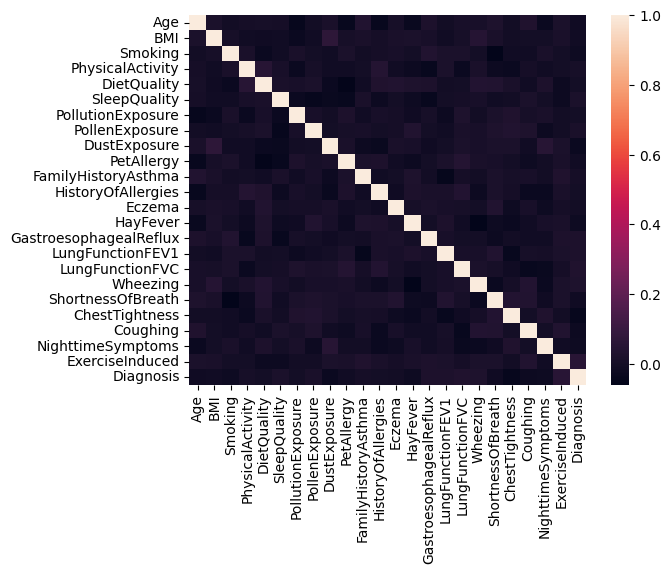

In [16]:
sns.heatmap(df.corr(method='spearman'))

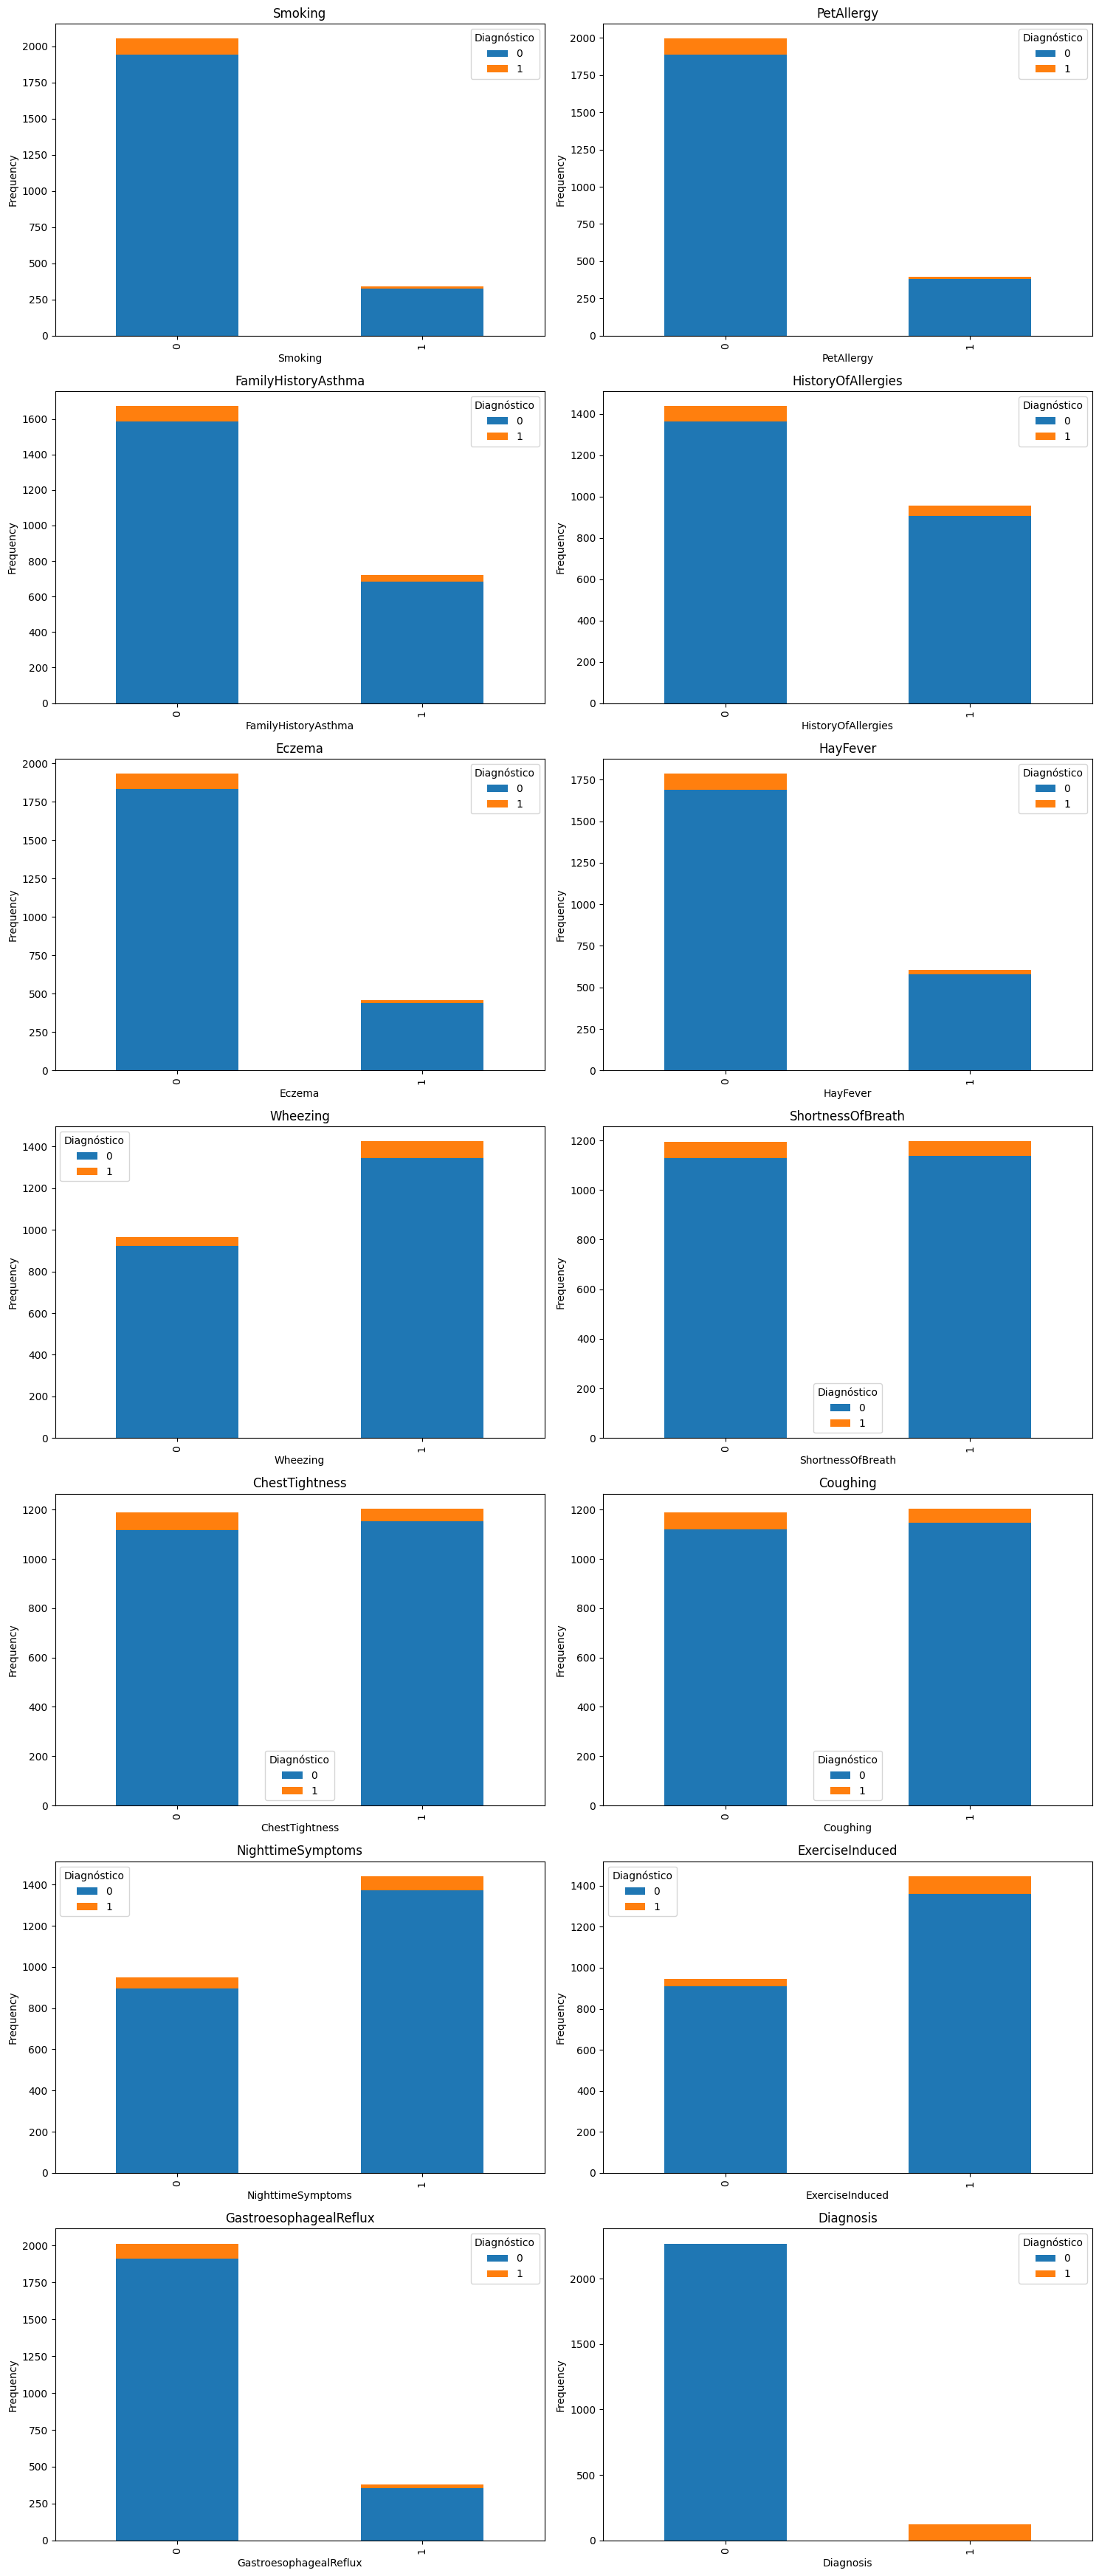

In [17]:
n_cols = 2
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

axs = axs.flatten()

# Plotar gráficos de barras empilhadas para cada coluna categórica
for i, column in enumerate(categorical_columns):
    df_counts = df.groupby([column, 'Diagnosis']).size().unstack(fill_value=0)
    df_counts.plot(kind='bar', ax=axs[i], stacked=True)
    axs[i].set_title(column)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Frequency')
    axs[i].legend(title='Diagnóstico')


plt.tight_layout()
plt.show()

In [18]:
df_non_categorial.describe()

,Age,BMI,PhysicalActivity,DietQuality,SleepQuality,PollutionExposure,PollenExposure,DustExposure,LungFunctionFEV1,LungFunctionFVC,Diagnosis
count,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000
mean,42.137960,27.244877,5.051786,5.022867,7.019012,5.013030,5.114221,4.981864,2.548564,3.741270,0.051839
std,21.606655,7.201628,2.903574,2.909980,1.732475,2.935605,2.893088,2.859192,0.861809,1.303689,0.221749
min,5.000000,15.031803,0.001740,0.003031,4.001437,0.001022,0.000659,0.002434,1.000459,1.500045,0.000000
25%,23.000000,20.968313,2.578333,2.432043,5.498500,2.432559,2.599996,2.467489,1.824113,2.607489,0.000000
50%,42.000000,27.052202,5.016881,5.115383,6.975839,5.036519,5.098452,4.903278,2.553244,3.734982,0.000000
75%,61.000000,33.555903,7.540234,7.544216,8.526950,7.630037,7.708836,7.432218,3.292897,4.864121,0.000000
max,79.000000,39.985611,9.995809,9.999904,9.996235,9.998964,9.999555,9.999708,3.999719,5.999421,1.000000


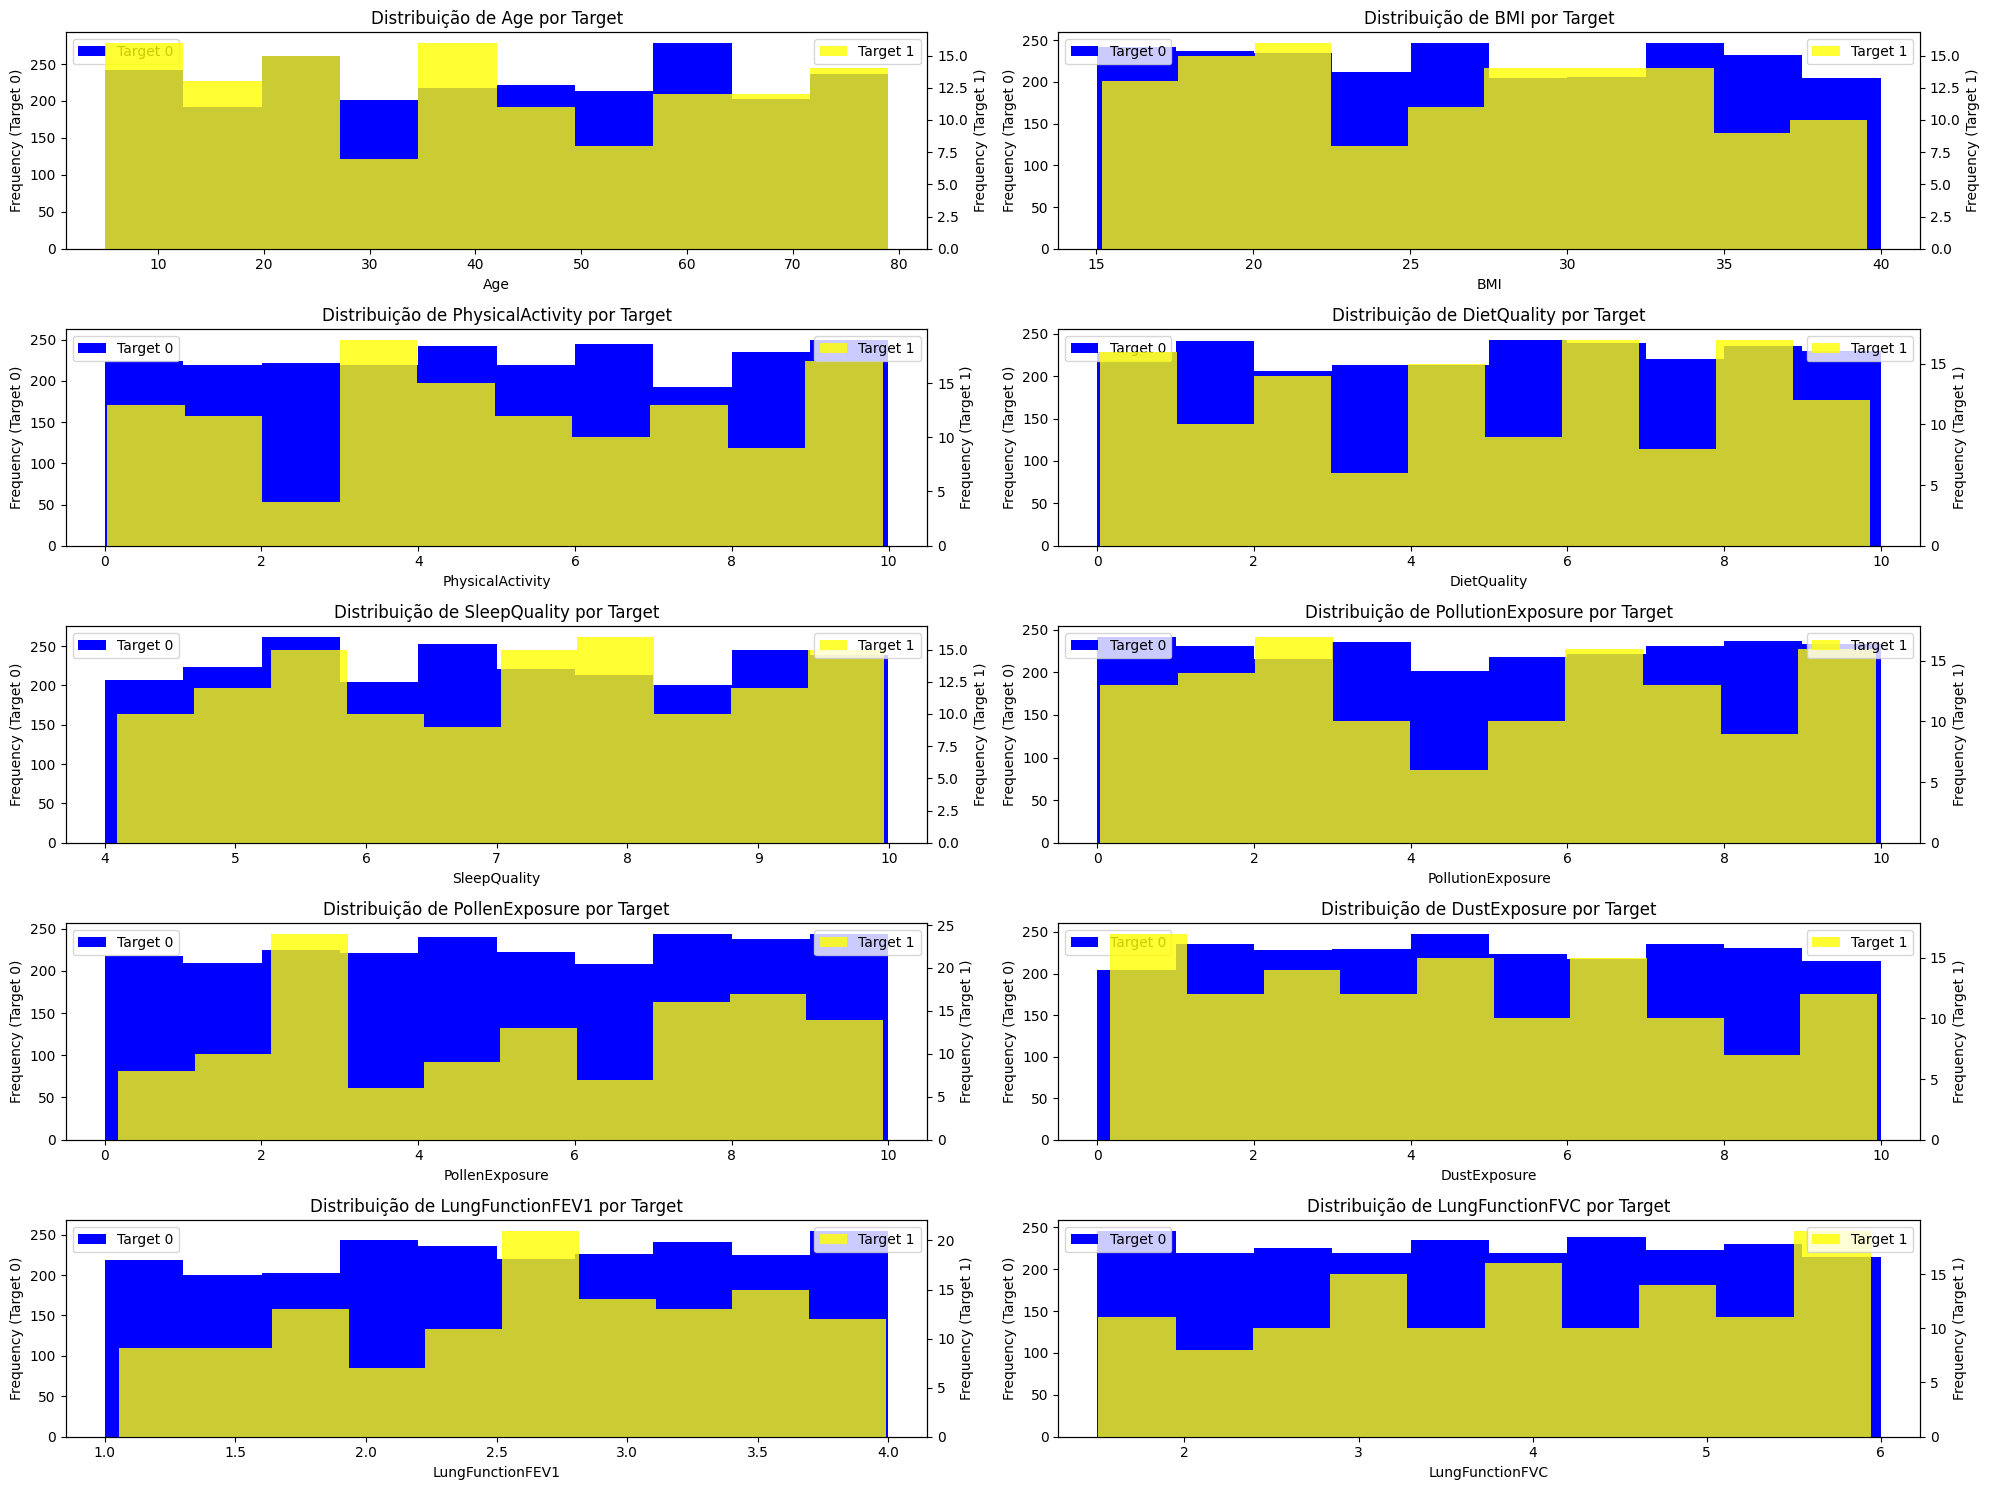

In [19]:
n_cols = 2
n_rows = (len(df_non_categorial.columns) - 1 + n_cols - 1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))

axs = axs.flatten()

for i, column in enumerate(df_non_categorial.columns.drop('Diagnosis')):
    ax = axs[i]
    df_non_categorial[df_non_categorial['Diagnosis'] == 0][column].plot(kind='hist', ax=ax, label='Target 0', color='blue', bins=10)
    
    ax2 = ax.twinx()
    df_non_categorial[df_non_categorial['Diagnosis'] == 1][column].plot(kind='hist', alpha = 0.8 ,ax=ax2, label='Target 1', color='yellow', bins=10)
    ax2.set_ylabel('Frequency (Target 1)')
    
    ax.set_title(f'Distribuição de {column} por Target')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency (Target 0)')
    
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')


plt.tight_layout()
plt.show()

# Pré-Processamento

In [20]:
df_vetorizado = df_non_categorial
scaler = StandardScaler()
df_vetorizado_scaled = scaler.fit_transform(df_vetorizado)

df_vetorizado_scaled = pd.DataFrame(df_vetorizado_scaled, columns=df_vetorizado.columns)

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical = encoder.fit_transform(df_categorial)
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(df_categorial.columns))

df_final = pd.concat([df_vetorizado_scaled, encoded_categorical_df], axis=1)
df_final = df_final.drop(columns=['Diagnosis', 'Diagnosis_1'])

# Treinamento

In [21]:
X = df_final
y = df['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=22)

param_distributions = [
    {
        'model': [LogisticRegression()],
        'model__C': uniform(0.01, 10),
        'model__penalty': ['l2'],
        'model__solver': ['liblinear']
    },
    {
        'model': [SVC()],
        'model__C': uniform(0.1, 10),
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale']
    },
    {
        'model': [GradientBoostingClassifier()],
        'model__n_estimators': randint(50, 150),
        'model__learning_rate': uniform(0.01, 0.1),
        'model__max_depth': [3, 5],
        'model__subsample': uniform(0, 1.0),
        'model__min_samples_split': randint(2, 10),
        'model__min_samples_leaf': randint(1, 4)
    },
    {
        'model': [AdaBoostClassifier()],
        'model__n_estimators': randint(50, 150),
        'model__learning_rate': uniform(0.01, 1)
    },
    {
        'model': [RandomForestClassifier()],
        'model__n_estimators': randint(100, 200),
        'model__max_depth': [10, 20, None],
        'model__min_samples_split': randint(2, 10),
        'model__min_samples_leaf': randint(1, 4),
        'model__bootstrap': [True]
    }
]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif, k=10)),
    ('pca', PCA(n_components=0.80)),
    ('model', LogisticRegression())
])

random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=100, cv=15, verbose=2, n_jobs=-1, random_state=22)

random_search.fit(X_train, y_train)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


c:\Ambientes\Scripts\Trabalho 2\venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=15,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('select', SelectKBest()),
                                             ('pca', PCA(n_components=0.8)),
                                             ('model', LogisticRegression())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions=[{'model': [LogisticRegression()],
                                         'model__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001EEE9CF1210>,
                                         'model__penalty...
                                         'model__max_depth': [10, 20, None],
                                         'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001EEE9CEB610>,
                                         'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001EEE8B5AED0>,
                                         'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001EEE8B58FD0>}],
                   random_state=42, verbose=2)

# Pós Processamento

In [23]:
print("Melhores parâmetros: ", random_search.best_params_)
print("Melhor modelo: ", random_search.best_estimator_)

test_score = random_search.score(X_test, y_test)
print("Acurácia no conjunto de teste: ", test_score)

y_pred = random_search.predict(X_test)
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred))
print("Relatório de classificação:\n", classification_report(y_test, y_pred))

Melhores parâmetros:  {'model': RandomForestClassifier(), 'model__bootstrap': True, 'model__max_depth': 10, 'model__min_samples_leaf': 3, 'model__min_samples_split': 3, 'model__n_estimators': 182}
Melhor modelo:  Pipeline(steps=[('scaler', StandardScaler()), ('select', SelectKBest()),
                ('pca', PCA(n_components=0.8)),
                ('model',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=3,
                                        min_samples_split=3,
                                        n_estimators=182))])
Acurácia no conjunto de teste:  0.9484679665738162
Matriz de confusão:
 [[681   0]
 [ 37   0]]
Relatório de classificação:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       681
           1       0.00      0.00      0.00        37

    accuracy                           0.95       718
   macro avg       0.47      0.50      0.49       718
weighted avg       0.90      0.95      0.92     

c:\Ambientes\Scripts\Trabalho 2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Ambientes\Scripts\Trabalho 2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Ambientes\Scripts\Trabalho 2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
